<a href="https://colab.research.google.com/github/AlexiaJM/AdversarialConsistentScoreMatching/blob/master/Clean_Basic_code_GAN_with_DSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## This is the heavily modified code from https://lernapparat.de/more-improved-wgan/

## 2020-06-07 Adding DAE from approach https://arxiv.org/abs/1907.05600

# Code

In [ ]:
# import everything
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
import os
import numpy
import math
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from matplotlib import pyplot
%matplotlib inline
pyplot.rcParams['figure.figsize'] = [12, 5.2]
import IPython

In [ ]:
opt_manualSeed = 15042017
print("Random Seed: ", opt_manualSeed)
random.seed(opt_manualSeed)
numpy.random.seed(opt_manualSeed)
torch.manual_seed(opt_manualSeed)
cudnn.benchmark = True

Random Seed:  15042017


In [ ]:
# Dataset generator largely form Improved Training of Wasserstein GAN code (see link above)
def inf_train_gen(DATASET='8gaussians', BATCH_SIZE=256):
    if DATASET == '25gaussians':
        dataset = []
        for i in range(100000//25):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = numpy.random.randn(2)*0.05
                    point[0] += 2*x
                    point[1] += 2*y
                    dataset.append(point)
        dataset = numpy.array(dataset, dtype='float32')
        numpy.random.shuffle(dataset)
        dataset /= 2.828 # stdev
        while True:
            for i in range(len(dataset)//BATCH_SIZE):
                yield torch.from_numpy(dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE, 
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5 # stdev plus a little
            yield torch.from_numpy(data)

    elif DATASET == '8gaussians':
    
        scale = 2.
        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (1./numpy.sqrt(2), -1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), -1./numpy.sqrt(2))
        ]
        centers = [(scale*x,scale*y) for x,y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = numpy.random.randn(2)*.02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = numpy.array(dataset, dtype='float32')
            dataset /= 1.414 # stdev
            yield torch.from_numpy(dataset)


In [ ]:
def denoise(scores, perturbed_samples, sigmas, target='z_score'):
    if target == 'dae':
        adjust = scores
    elif target == 'diff':
        adjust = scores + perturbed_samples
    elif target == 'zscore':
        adjust = scores*sigmas + perturbed_samples
    return adjust

In [ ]:
# exp_reduct: exponentialy reduce the alpha over time [alpha_new = alpha*exp_reduct^(n_iterations)]
@torch.no_grad()
def Langevin_sampling(x_mod, netG, target, sigmas, T, alpha, batchSize, n_steps_each, cond, exp_reduct = 1, rand_alpha=False, consistent=False):
    noisevar = torch.FloatTensor(batchSize, 1).cuda()
    uncorr = x_mod

    if consistent:
        epsilon = alpha
        print(epsilon)
        gamma = sigmas[0] / sigmas[1]
        s = np.power(gamma, -1 / n_steps_each)
        _f = lambda e: 1 - ((1 - e)/s) ** 2
        _interior = _f(epsilon)
        while _interior < 0:
            epsilon *= 2
            _interior = _f(epsilon)
            print(f"[INFO] learning rate too small, multiplying by 2 to [{epsilon * (sigmas[-1] ** 2)}]")
        beta = np.sqrt(_interior)
        spread_sigmas = np.geomspace(sigmas[0], sigmas[-1], n_steps_each * (len(sigmas) - 1) + 1)
        for c, sigma in enumerate(spread_sigmas):
            score_net = netG(x_mod)  # s(x) = (uncorrupt(x) - x) / sigma_k
            uncorr = denoise(score_net, x_mod, sigma, target=target)
            x_mod = x_mod + (epsilon * sigma) * score_net
            x_mod += sigma * s * beta * torch.randn_like(x_mod)
    else:
        for c, sigma in enumerate(sigmas):
            for s in range(n_steps_each):
                noisevar.fill_(np.sqrt(T * 2 * alpha)*sigma)
                noise = torch.randn_like(x_mod) * noisevar
                x_corrupt = x_mod + noise # Adding noise first
                if cond:
                    x_corrupt_ = torch.cat((x_corrupt, noisevar), 1)
                else:
                    x_corrupt_ = x_corrupt
                uncorr = denoise(netG(x_corrupt_), x_corrupt, sigma, target=target)
                x_mod = (1 - alpha) * x_mod + alpha*uncorr
                alpha = alpha*exp_reduct
    return x_mod.detach().cpu().numpy(), uncorr.detach().cpu().numpy()


In [ ]:
# Generates and saves a plot of the true distribution, the generator, and the critic.

## 2020-06-17: Now this is the sampling Langevin process
class ImageGenerator:
  def __init__(self, sigmas, prefix='frame', noise_dim=2, title='', n_steps_each=10, T=1, alpha=.2, cond = False, target='z_score', opt_batchSize=256, RANGE = 3, exp_reduct = 1, rand_alpha = False, paper_plot = False, consistent=False):
    self.prefix = prefix
    self.frame_index = 1
    self.noise_dim = noise_dim
    self.title = title
    self.cond = cond
    self.sigmas = sigmas
    self.n_steps_each = n_steps_each
    self.T = T
    self.alpha = alpha
    self.target = target
    self.opt_batchSize = opt_batchSize
    self.RANGE = RANGE
    self.exp_reduct = exp_reduct
    self.rand_alpha = rand_alpha
    self.paper_plot = paper_plot
    self.consistent = consistent

  def __call__(self, true_dist, losses, netG, netD):
    N_POINTS = 128

    with torch.no_grad():
        points = numpy.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
        points[:,:,0] = numpy.linspace(-self.RANGE, self.RANGE, N_POINTS)[:,None]
        points[:,:,1] = numpy.linspace(-self.RANGE, self.RANGE, N_POINTS)[None,:]
        points = points.reshape((-1,2))
        points = Variable(torch.from_numpy(points).cuda())

        # Starting from real samples
        samples_real, samples_real_uncorr = Langevin_sampling(true_dist, netG, target=self.target, sigmas=self.sigmas, T=self.T, alpha=self.alpha, batchSize=self.opt_batchSize, n_steps_each=self.n_steps_each, cond=self.cond, exp_reduct = self.exp_reduct, rand_alpha=self.rand_alpha, consistent=self.consistent)

        # Starting from U(0,1)
        x_mod = torch.FloatTensor().resize_(self.opt_batchSize, 2)
        x_mod.uniform_(-self.RANGE, self.RANGE) # init
        x_mod = x_mod.cuda()
        samples_unif, samples_unif_uncorr = Langevin_sampling(x_mod, netG, target=self.target, sigmas=self.sigmas, T=self.T, alpha=self.alpha, batchSize=self.opt_batchSize, n_steps_each=self.n_steps_each, cond=self.cond, exp_reduct = self.exp_reduct, rand_alpha=self.rand_alpha, consistent=self.consistent)

        disc_points = netD(points)
        
        disc_map = disc_points.data.cpu().numpy()
        
        pyplot.clf()
        if self.paper_plot:
            ax1 = pyplot.subplot(1,2,1)
            ax1.title.set_text('Final')
            plt.xlim((-2.5,2.5))
            plt.ylim((-2.5,2.5))
            plt.axis('off')
        else:
            ax1 = pyplot.subplot(1,4,1)
            ax1.title.set_text('Final (init=uniform)')
        x = y = numpy.linspace(-self.RANGE, self.RANGE, N_POINTS)

        true_dist = true_dist.cpu().numpy()
        pyplot.scatter(true_dist[:, 0], true_dist[:, 1], c='orange',marker='+')
        pyplot.scatter(samples_unif[:, 0],   samples_unif[:, 1],   c='green', marker='+')

        if not self.paper_plot:
            ax2 = pyplot.subplot(1,4,2)
            ax2.title.set_text('Final (init=real)')
            pyplot.scatter(true_dist[:, 0], true_dist[:, 1], c='orange',marker='+')
            pyplot.scatter(samples_real[:, 0],   samples_real[:, 1],   c='green', marker='+')

        if self.paper_plot:
            ax3 = pyplot.subplot(1,2,2)
            ax3.title.set_text('Denoised')
            plt.axis('off')
            plt.xlim((-2.5,2.5))
            plt.ylim((-2.5,2.5))
        else:
            ax3 = pyplot.subplot(1,4,3)
            ax3.title.set_text('Denoised (init=uniform)')
        pyplot.scatter(true_dist[:, 0], true_dist[:, 1], c='orange',marker='+')
        pyplot.scatter(samples_unif_uncorr[:, 0],   samples_unif_uncorr[:, 1],   c='green', marker='+')

        if not self.paper_plot:
            ax4 = pyplot.subplot(1,4,4)
            ax4.title.set_text('Denoised (init=real)')
            pyplot.scatter(true_dist[:, 0], true_dist[:, 1], c='orange',marker='+')
            pyplot.scatter(samples_real_uncorr[:, 0],   samples_real_uncorr[:, 1],   c='green', marker='+')

        if self.prefix is not None:
            pyplot.savefig(self.prefix+self.title+'.jpg')

        IPython.display.clear_output(wait=True)
        IPython.display.display(pyplot.gcf())
        self.frame_index += 1

In [ ]:
class MyLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(MyLeakyReLU, self).__init__()
        self.negative_slope = negative_slope
    def forward(self, x):
        return torch.clamp(x, min=0.0)+torch.clamp(x, max=0.0)*self.negative_slope

class ToyGAN_G(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=2, noise_dim=2):
        super(ToyGAN_G, self).__init__()
        self.dim_hidden, self.dim_out, self.noise_dim = dim_hidden, dim_out, noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_out)
            )
    def forward(self, x):
        x = self.net(x)
        return x

class ToyGAN_D(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=2):
        super(ToyGAN_D, self).__init__()
        self.dim_hidden, self.dim_gen_out = dim_hidden, dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, 1)
            )
    def forward(self, x):
        x = self.net(x)
        return x.view(-1)

In [ ]:
### This code always use the unconditional DAE setting, so adding noise and denoising
### It does the sampling while training to make things easy to diagnose (every plot_often iterations)

#### Training of GAN
## Loss_D changes the loss function, you can try different ones, WGAN uses gradient penalty
## Diters = 5 is what they use with WGAN-GP normally, we want it to work with 1
## you can force any loss function to use gradient penalty with "grad_penalty=True"
## grad_penalty_ignore_real=True force the penalty to only apply to fake data (instead of interpolation)
## grad_penalty_ignore_fake=True force the penalty to only apply to real data
## augmented_grad does augmented langrangian with gradient penalty
## penalty_weight is the weight for the gradient penalty

## RANGE = 3 is the range of the plot and uniform distribution for DAE sampling

#### Training of DAE
## GAN_loss: Scaling for the GAN loss of the generator, if zero we do not use GAN (there is a whole zoo, check code)
## DAE_loss: Scaling for the DAE loss of the generator
## sigma_range: Range of pertrubations sigmas
## n_sigma: Number of sigma to sample from in the range
## sigma_lin_progress: If yes, uses linear progression, otherwise, uses geometric progression of sigmas
## cond: Generator will condition on sigma
## target = 'zscore' (x-x_corrupt)/sigma or 'diff' (x-x_corrupt) or 'dae' (x)
## DAE_loss_type = 'L2' or 'L1'

#### Sampling of DAE
## n_steps_each=10: Number of sampling steps
## T: Temperature of sampling
## alpha: interpolation coefficient (step size) of sampling
## samp_sigma_range: Range of pertrubations sigmas
## samp_n_sigma: Number of sigma to sample from in the range
## samp_sigma_lin_progress: If yes, uses linear progression, otherwise, uses geometric progression of sigmas
## exp_reduct: exponentialy reduce the alpha over time [alpha_new = alpha*exp_reduct^(n_iterations)]
## added_noise: apply N(0, added_noise) to real data and try to recover that
## rand_alpha: if True randomly sample an alpha betwen .01 and .4 at every step
## consistent: If True uses Consistent sampling
## paper_plot: If True make Plots nice

def run_experiment(lr_D = 0.00005, lr_G = 0.00005, seed = [777], opt_dataset = 'swissroll', # 8gaussians | swissroll | 25gaussians
                   loss_D = 1, Diters=1, opt_niter = 5000, opt_batchSize=256, opt_beta1=0.9, # .9 for DAE, .5 for GAN 
                   opt_beta2=.999, opt_cuda = True, opt_adam = True, opt_rho = 1e-5, # for augmented langrangian if using
                   RANGE = 3,
                   penalty_weight = 10, y_mid=.50, title='', prefix = "/home/alexia/Dropbox/Ubuntu_ML/Output/Spiral/", 
                   Giters=1, plot_often=500, grad_penalty_ignore_real=False, grad_penalty_ignore_fake=False, 
                   delta=1, no_penal=False, grad_penalty=False, print_C=False, var_print=False, augmented_fisher=False, 
                   augmented_variance=False, augmented_grad=False,
                   GAN_loss = 0, DAE_loss = 10, sigma_range = [0.01,1], n_sigma = 10, sigma_lin_progress = False, DAE_loss_type = 'L2', cond = False,
                   samp_sigma_range = [0.01,1], samp_n_sigma = 10, samp_sigma_lin_progress = False, n_steps_each=10, T=1, alpha=.2, target='zscore',
                   exp_reduct = 1, added_noise = 0, rand_alpha = False, paper_plot = False, consistent=False):

    distance_to_fake = [0, 0, 0, 0, 0]
    distance_to_real = [0, 0, 0, 0, 0]
    distance_total = [0, 0, 0, 0, 0]
    for seed_i, sss in enumerate(seed, 0):

        print("Random Seed: ", sss)
        random.seed(sss)
        numpy.random.seed(sss)
        torch.manual_seed(sss)
        cudnn.benchmark = True

        data_generator = inf_train_gen(opt_dataset, opt_batchSize)
        D = ToyGAN_D()
        if cond:
            G = ToyGAN_G(noise_dim=3) # Extra dim to handle sigma
        else:
            G = ToyGAN_G()

        # Criterion
        BCE_stable = torch.nn.BCEWithLogitsLoss()
        BCE_stable_noreduce = torch.nn.BCEWithLogitsLoss(reduce=False)

        # Soon to be variables
        x = torch.FloatTensor(opt_batchSize, 2)
        x_fake = torch.FloatTensor(opt_batchSize, 2)
        y = torch.FloatTensor(opt_batchSize)
        y2 = torch.FloatTensor(opt_batchSize)
        u = torch.FloatTensor(opt_batchSize, 1)
        perturbation = torch.FloatTensor(opt_batchSize,2)
        grad_outputs = torch.ones(opt_batchSize)
        w_fisher = torch.FloatTensor([0.50]) # lagrange multipliers
        w_grad = torch.FloatTensor([0.50]) # lagrange multipliers
        mone = -torch.FloatTensor([1])
        unif_noise = torch.FloatTensor(opt_batchSize, 2)

        # Everything cuda
        if opt_cuda:
            G = G.cuda()
            D = D.cuda()
            BCE_stable.cuda()
            BCE_stable_noreduce.cuda()
            x = x.cuda()
            x_fake = x_fake.cuda()
            grad_outputs = grad_outputs.cuda()
            y = y.cuda()
            y2 = y2.cuda()
            u = u.cuda()
            mone = mone.cuda()
            w_fisher = w_fisher.cuda()
            w_grad = w_grad.cuda()
            perturbation = perturbation.cuda()
            unif_noise = unif_noise.cuda()

        # Now Variables
        x = Variable(x)
        x_fake = Variable(x_fake)
        y = Variable(y)
        y2 = Variable(y2)
        w_fisher = Variable(w_fisher, requires_grad=True)
        w_grad = Variable(w_grad, requires_grad=True)
        unif_noise = Variable(unif_noise, requires_grad=True)

        # Setting the title for the file saved
        if loss_D == 1:
            title = 'GAN_'
        title = title + 'seed%d' % sss 

        # Setting up the sigmas

        # Sigmas for training
        if sigma_lin_progress:
            sigmas = np.linspace(sigma_range[1], sigma_range[0], n_sigma)
        else:
            sigmas = np.geomspace(sigma_range[1], sigma_range[0], n_sigma)
        sigmas = torch.tensor(sigmas, dtype=torch.float).cuda()

        # Sigmas for sampling
        if samp_sigma_lin_progress:
            samp_sigmas = np.linspace(samp_sigma_range[1], samp_sigma_range[0], samp_n_sigma)
        else:
            samp_sigmas = np.geomspace(samp_sigma_range[1], samp_sigma_range[0], samp_n_sigma)
        samp_sigmas = torch.tensor(samp_sigmas, dtype=torch.float)
        generate_image = ImageGenerator(sigmas=samp_sigmas, prefix=prefix, title=title, n_steps_each=n_steps_each, T=T, alpha=alpha, cond=cond, target=target, RANGE=RANGE, exp_reduct=exp_reduct, rand_alpha=rand_alpha, paper_plot=paper_plot, consistent=consistent)

        if opt_adam:
            optimizerD = optim.Adam(D.parameters(), lr=lr_D, betas=(opt_beta1, opt_beta2))
            optimizerG = optim.Adam(G.parameters(), lr=lr_G, betas=(opt_beta1, opt_beta2))
        else:
            optimizerD = optim.RMSprop(D.parameters(), lr = lr_D)
            optimizerG = optim.RMSprop(G.parameters(), lr = lr_G)
        optimizer_fisher = optim.SGD([w_fisher], lr=opt_rho)
        optimizer_grad = optim.SGD([w_grad], lr=opt_rho)

        for p in G.parameters():
            p.requires_grad = True

        ## Fitting model
        losses = []
        for i in range(opt_niter):

            if GAN_loss != 0:

                ########################
                # (1) Update D network #
                ########################

                for p in D.parameters():
                    p.requires_grad = True

                # train the discriminator Diters times
                for j in range(Diters):

                    D.zero_grad()
                    images = next(data_generator)
                    if opt_cuda:
                        images = images.cuda()
                    # Transfer batch of images to x
                    x.data.resize_as_(images).copy_(images)
                    y_pred = D(x)

                    labels = torch.randint(0, len(sigmas), (x.shape[0],), device=x.device)
                    std = sigmas[labels].view(x.shape[0], *([1] * len(x.shape[1:])))
                    noise = torch.randn_like(x) * std
                    x_corrupt = x + noise
                    if cond:
                        x_corrupt_ = torch.cat((x_corrupt, std), 1)
                    else:
                        x_corrupt_ = x_corrupt
                    uncorr =  denoise(G(x_corrupt_), x_corrupt, std, target=target)
                    x_fake.data.resize_(uncorr.data.size()).copy_(uncorr.data)
                    y.data.resize_(opt_batchSize).fill_(0)
                    # Detach y_pred from the neural network G and put it inside D
                    y_pred_fake = D(x_fake.detach())

                    y.data.resize_(opt_batchSize).fill_(1)
                    y2.data.resize_(opt_batchSize).fill_(0)
                
                    if print_C:
                        print(torch.mean(y_pred))
                        print(torch.std(y_pred))

                    if loss_D == 1 or loss_D == 4 or loss_D == 9:
                        errD = BCE_stable(y_pred, y) + BCE_stable(y_pred_fake, y)
                    if loss_D == 2:
                        errD = torch.mean((y_pred - y) ** 2) + torch.mean((y_pred_fake) ** 2)
                    if loss_D == 3:
                        errD = -torch.mean(y_pred) + torch.mean(y_pred_fake)
                    if loss_D == 6 or loss_D == 8:
                        errD = -torch.mean((y_pred - y_pred_fake) ** 2)
                    if loss_D == 10: # RpGAN
                        errD = 2*BCE_stable(y_pred - y_pred_fake, y)
                    if loss_D == 11: # RpLSGAN
                        errD = torch.mean((y_pred - y_pred_fake - y) ** 2)
                    if loss_D == 20: #RaGAN
                        errD = BCE_stable(y_pred - torch.mean(y_pred_fake), y) + BCE_stable(torch.mean(y_pred_fake) - y_pred, y2)
                    if loss_D == 21: #RaLSGAN
                        errD = .5*torch.mean((y_pred - torch.mean(y_pred_fake) - y) ** 2) + .5*torch.mean((y_pred_fake - torch.mean(y_pred) + y) ** 2)
                    errD.backward()

                    if var_print:
                        print(torch.var(y_pred, unbiased=False))
                        print(torch.var(y_pred_fake, unbiased=False))
                        print("-------------------------")
                        
                    if ((grad_penalty or loss_D in [3,4,6,7,9]) and not no_penal and not augmented_grad):
                        # WGAN-GP penatly
                        u.resize_(opt_batchSize, 1)
                        u.uniform_(0,1)
                        if (grad_penalty_ignore_real):
                            x_both = x_fake.data
                        else:
                            x_both = x.data*u + x_fake.data*(1-u)
                        x_both = x_both.cuda()
                        x_both = Variable(x_both, requires_grad=True)
                        lip_loss = 0
                        grad = torch.autograd.grad(outputs=D(x_both), inputs=x_both, grad_outputs=grad_outputs, retain_graph=True, create_graph=True, only_inputs=True)[0]
                        lip_loss = lip_loss + penalty_weight*((grad.norm(2, 1) - delta) ** 2).mean()
                        errD = errD + lip_loss
                        #print(lip_loss)
                        lip_loss.backward()
                    if augmented_fisher:
                        u.resize_(opt_batchSize, 1)
                        u.uniform_(0,1)
                        if (grad_penalty_ignore_real):
                            x_both = x_fake.data
                        else:
                            x_both = x.data*u + x_fake.data*(1-u)
                        x_both = x_both.cuda()
                        x_both = Variable(x_both, requires_grad=True)
                        # Fisher augmented langrangian
                        constraint = 1 - torch.mean(D(x_both)**2)
                        aug_loss = -w_fisher*(constraint) + (opt_rho/2)*(constraint)**2
                        aug_loss.backward()
                    if augmented_variance:
                        u.resize_(opt_batchSize, 1)
                        u.uniform_(0,1)
                        if (grad_penalty_ignore_real):
                            x_both = x_fake.data
                        else:
                            x_both = x.data*u + x_fake.data*(1-u)
                        x_both = x_both.cuda()
                        x_both = Variable(x_both, requires_grad=True)
                        # Varianced augmented langrangian
                        constraint = 1 - torch.var(D(x_both), unbiased=False)
                        aug_loss = -w_fisher*(constraint) + (opt_rho/2)*(constraint)**2
                        aug_loss.backward()
                    if augmented_grad:
                        u.resize_(opt_batchSize, 1)
                        u.uniform_(0,1)
                        if (grad_penalty_ignore_real):
                            x_both = x_fake.data
                        else:
                            x_both = x.data*u + x_fake.data*(1-u)
                        x_both = x_both.cuda()
                        x_both = Variable(x_both, requires_grad=True)
                        grad = torch.autograd.grad(outputs=D(x_both), inputs=x_both, grad_outputs=grad_outputs, retain_graph=True, create_graph=True, only_inputs=True)[0]
                        # Sobolev augmented langrangian
                        aug_loss = 0
                        constraint = 1 - torch.mean(grad.norm(2, 1) ** 2)
                        aug_loss = -w_grad*(constraint) + (opt_rho/2)*(constraint)**2
                        aug_loss.backward()
                    optimizerD.step()
                    if augmented_fisher or augmented_variance:
                        w_fisher.data += opt_rho * w_fisher.grad.data
                        w_fisher.grad.zero_()
                    if augmented_grad:
                        w_grad.data += opt_rho * w_grad.grad.data
                        w_grad.grad.zero_()
            else:
                errD = 0

            ########################
            # (2) Update G network #
            ########################

            # Make it a tiny bit faster
            for p in D.parameters():
                p.requires_grad = False

            for j in range(Giters):
                G.zero_grad()
                y.data.resize_(opt_batchSize).fill_(1)

                images = next(data_generator)
                if opt_cuda:
                    images = images.cuda()
                # Transfer batch of images to x
                x.data.resize_as_(images).copy_(images)
                if added_noise != 0:
                    x = x + torch.randn_like(x)*added_noise

                labels = torch.randint(0, len(sigmas), (x.shape[0],), device=x.device)
                std = sigmas[labels].view(x.shape[0], *([1] * len(x.shape[1:])))
                noise = torch.randn_like(x) * std
                x_corrupt = x + noise
                if cond:
                    x_corrupt_ = torch.cat((x_corrupt, std), 1)
                else:
                    x_corrupt_ = x_corrupt
                score = G(x_corrupt_)
                fake = denoise(score, x_corrupt, std, target=target)

                y_pred_fake = D(fake)

                if GAN_loss != 0:
                    if loss_D == 1 or loss_D == 4:
                        errG = BCE_stable(y_pred_fake, y)
                    if loss_D == 2:
                        errG = torch.mean((y_pred_fake - y) ** 2)
                    if loss_D == 3:
                        errG = -torch.mean(y_pred_fake)
                    if loss_D == 10: # RpGAN
                        y_pred = D(x)
                        errG = 2*BCE_stable(y_pred_fake - y_pred, y)
                    if loss_D == 11: # RpLSGAN
                        y_pred = D(x)
                        errG = torch.mean((y_pred_fake - y_pred - y) ** 2)
                    if loss_D == 20: #RaGAN
                        y_pred = D(x)
                        errG = BCE_stable(y_pred - torch.mean(y_pred_fake), y2) + BCE_stable(torch.mean(y_pred_fake) - y_pred, y)
                    if loss_D == 21: #RaLSGAN
                        y_pred = D(x)
                        errG = .5*torch.mean((y_pred - torch.mean(y_pred_fake) + y) ** 2) + .5*torch.mean((y_pred_fake - torch.mean(y_pred) - y) ** 2)
                    errG = GAN_loss*errG
                else:
                    errG = 0
                if DAE_loss != 0:
                    if target == 'zscore':
                        target_ = (x - x_corrupt)/std
                    if target == 'diff':
                        target_ = x - x_corrupt
                    elif target == 'dae':
                        target_ = x
                    if DAE_loss_type == 'L1':
                        errDAE = torch.abs(score - target_).mean(1)
                    elif DAE_loss_type == 'L2':
                        errDAE = (0.5 * ((score - target_) ** 2)).mean(1)
                    # Scaling
                    if target == 'diff':
                        variance = std
                        if DAE_loss_type == 'L2':
                            variance = std ** 2
                        variance = 1 / variance
                        errDAE = errDAE*variance
                    errDAE = DAE_loss*errDAE.mean()
                else:
                    errDAE = 0
                errG_total = errG + errDAE
                errG_total.backward(retain_graph=True)
                D_G = y_pred_fake.data.mean()
                optimizerG.step()
            
            if (i+1) % plot_often == 0:
                if GAN_loss != 0:
                    losses.append(errD.data.item())
                generate_image(images, losses, G, D)
                print('[%d/%d] Loss_D: %f Loss_G: %f Loss_G_dae: %f'
                % (i, opt_niter,
                errD, errG, errDAE))

        if GAN_loss != 0:
            losses.append(errD.data.item())
        generate_image(images, losses, G, D)
        IPython.display.clear_output(wait=True)
        print('[%d/%d] Loss_D: %f Loss_G: %f Loss_G_dae: %f'
            % (i, opt_niter,
            errD, errG, errDAE))

        #### This parts normally calculate a sort of metric to see how well its doing.
        #### Will need to fix later
        del errG
        del errD
        del errDAE
        del D
        ## Calculating and logging results
        random.seed(7)
        numpy.random.seed(7)
        torch.manual_seed(7)
        from scipy import spatial

        opt_test_size = 5000

        # Generate real
        data_generator = inf_train_gen(opt_dataset, BATCH_SIZE=opt_test_size)
        x = next(data_generator)
        x = x.numpy()

        # Generate fake (Initialization to U(0,1))
        opt_test_size = 5000
        x_mod = torch.FloatTensor().resize_(opt_test_size, 2)
        x_mod.uniform_(-RANGE, RANGE) # init
        x_mod = x_mod.cuda()
        _, x_fake = Langevin_sampling(x_mod, G, target=target, sigmas=samp_sigmas, T=T, alpha=alpha, batchSize=opt_test_size, n_steps_each=n_steps_each, cond=cond, exp_reduct=exp_reduct, rand_alpha=rand_alpha)

        # Distance
        Tree_x = spatial.KDTree(x)
        Tree_x_fake = spatial.KDTree(x_fake)

        for x_i in range(len(x)):
            distance_to_fake[seed_i] = distance_to_fake[seed_i] + Tree_x_fake.query(x[x_i])[0]
            distance_to_real[seed_i] = distance_to_real[seed_i] + Tree_x.query(x_fake[x_i])[0]
        distance_to_real[seed_i] = distance_to_real[seed_i] / opt_test_size
        distance_to_fake[seed_i] = distance_to_fake[seed_i] / opt_test_size
        distance_total[seed_i] = distance_to_real[seed_i] + distance_to_fake[seed_i]

    if prefix is not None:
        log_output = open(f"{prefix}.txt", 'a')
    else:
        log_output = None
    import statistics
    print('%s: Distance_total = %f, Distance_to_real = %f, Distance_to_fake = %f' % (title, statistics.mean(distance_total), statistics.mean(distance_to_real), statistics.mean(distance_to_fake)), file=log_output)

In [ ]:
%matplotlib inline
pyplot.rcParams['figure.figsize'] = [12, 5.2]

# Basic experiments on Swiss Roll data

## unconditional networks

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.135972
GAN_seed1: Distance_total = 0.048490, Distance_to_real = 0.044547, Distance_to_fake = 0.003943


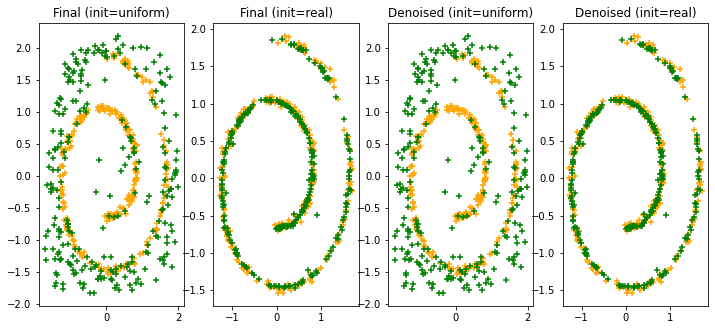

In [ ]:
# uncond, 1 step alpha=1, sigma=.1
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=1, alpha=1, samp_n_sigma = 1, lr_G = 0.001, target='zscore')

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 2.964787
GAN_seed1: Distance_total = 0.010392, Distance_to_real = 0.006875, Distance_to_fake = 0.003517


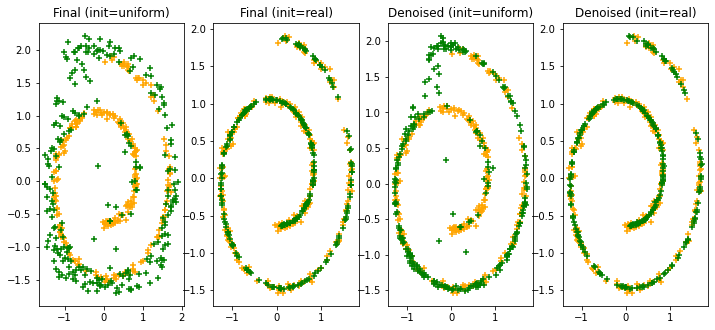

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1 # Best results so far!
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, target='zscore')

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.662372
GAN_seed1: Distance_total = 0.040873, Distance_to_real = 0.027485, Distance_to_fake = 0.013388


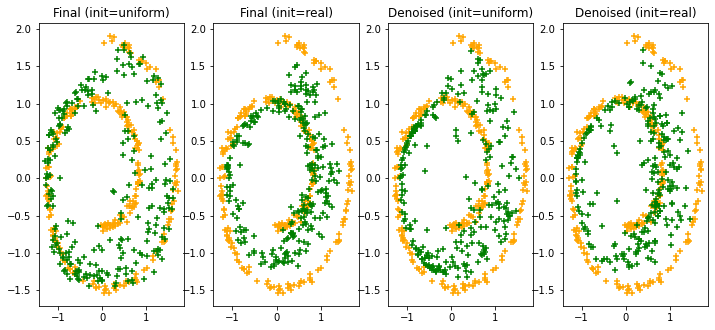

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.5
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.5,.5], n_sigma = 1, samp_sigma_range = [.5,.5], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.001, target='zscore')

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.662372
GAN_seed1: Distance_total = 0.031470, Distance_to_real = 0.019928, Distance_to_fake = 0.011542


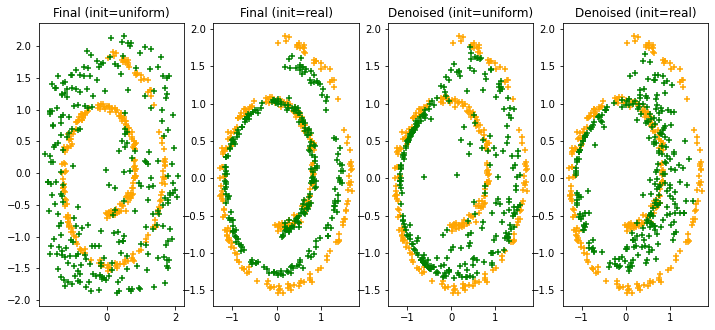

In [ ]:
## uncond, 10 steps alpha=.1, sigma=.5
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.5,.5], n_sigma = 1, samp_sigma_range = [.5,.5], n_steps_each=10, alpha=.1, samp_n_sigma = 1, lr_G = 0.001, target='zscore')

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.662372
GAN_seed1: Distance_total = 0.023056, Distance_to_real = 0.014561, Distance_to_fake = 0.008495


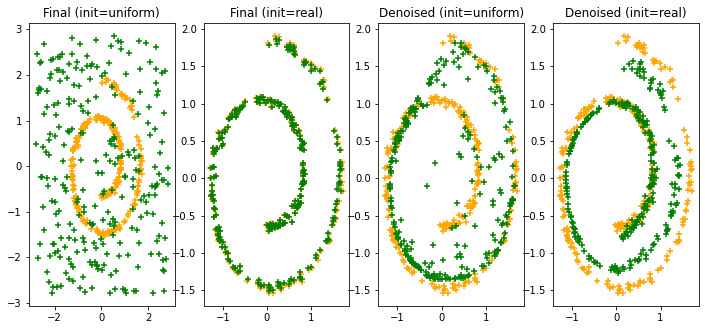

In [ ]:
## uncond, 10 steps alpha=.01, sigma=.5
# Final better than denoised for real data!
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.5,.5], n_sigma = 1, samp_sigma_range = [.5,.5], n_steps_each=10, alpha=.01, samp_n_sigma = 1, lr_G = 0.001, target='zscore')

## Hybrid GAN + DAE

[1999/2000] Loss_D: 0.494182 Loss_G: 0.002542 Loss_G_dae: 4.511052
seed1: Distance_total = 0.004601, Distance_to_real = 0.001618, Distance_to_fake = 0.002984


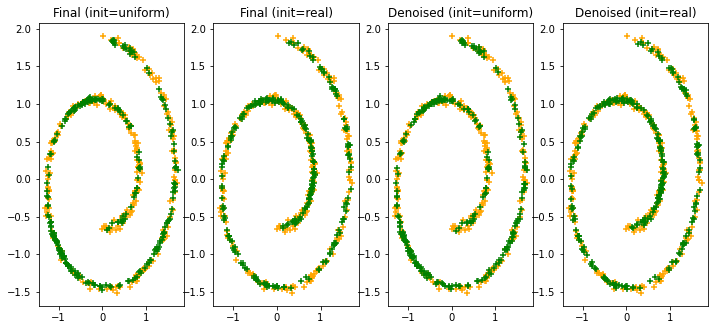

In [ ]:
# uncond, 10 steps alpha=.5, 10 sigma from [.01,.2] (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.01,.2], n_sigma = 10, samp_sigma_range = [.01,.2], n_steps_each=10, alpha=.5, samp_n_sigma = 10, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L2', target='zscore')

# Basic experiments on 25 Gaussians

## unconditional networks

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.292901
GAN_seed1: Distance_total = 0.014991, Distance_to_real = 0.013155, Distance_to_fake = 0.001836


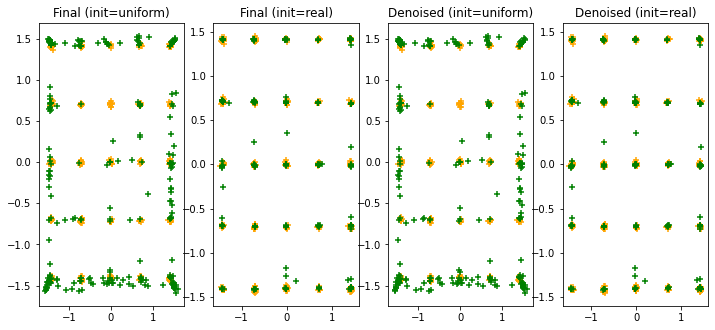

In [ ]:
# uncond, 1 step alpha=1, sigma=.1
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=1, alpha=1, samp_n_sigma = 1, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.305167
GAN_seed1: Distance_total = 0.005515, Distance_to_real = 0.002861, Distance_to_fake = 0.002655


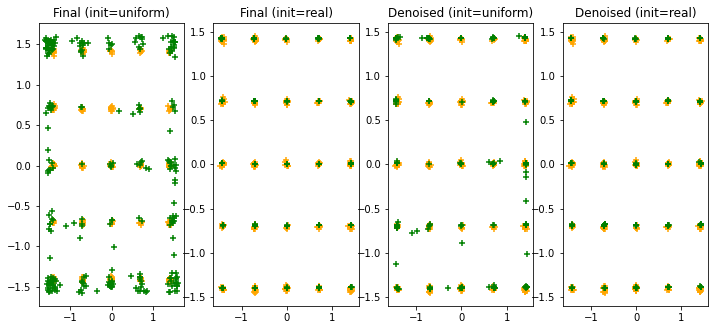

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1 # Best results so far!
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.873696
GAN_seed1: Distance_total = 0.054893, Distance_to_real = 0.045465, Distance_to_fake = 0.009428


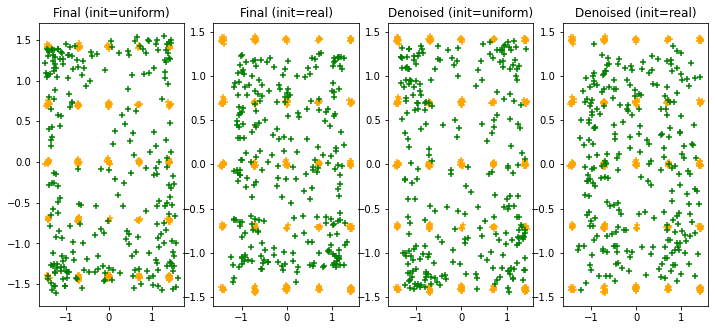

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.5
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.5,.5], n_sigma = 1, samp_sigma_range = [.5,.5], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.873696
GAN_seed1: Distance_total = 0.047397, Distance_to_real = 0.038813, Distance_to_fake = 0.008584


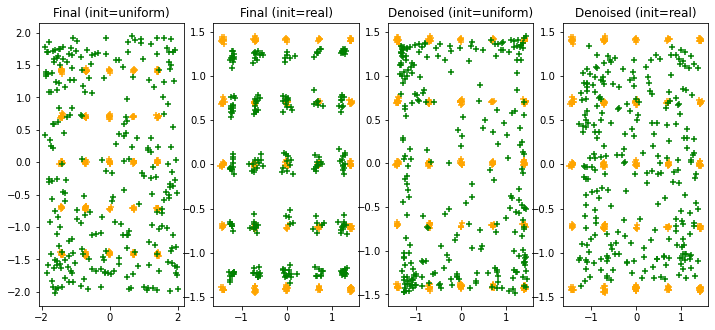

In [ ]:
## uncond, 10 steps alpha=.1, sigma=.5
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.5,.5], n_sigma = 1, samp_sigma_range = [.5,.5], n_steps_each=10, alpha=.1, samp_n_sigma = 1, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.873696
GAN_seed1: Distance_total = 0.041547, Distance_to_real = 0.033644, Distance_to_fake = 0.007903


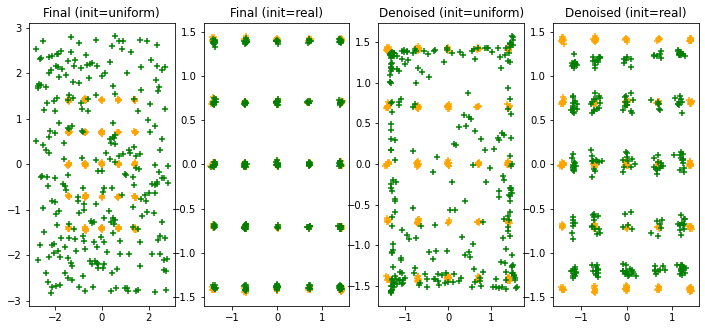

In [ ]:
## uncond, 10 steps alpha=.01, sigma=.5
# Final better than denoised for real data!
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.5,.5], n_sigma = 1, samp_sigma_range = [.5,.5], n_steps_each=10, alpha=.01, samp_n_sigma = 1, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.125755
GAN_seed1: Distance_total = 0.011024, Distance_to_real = 0.007560, Distance_to_fake = 0.003464


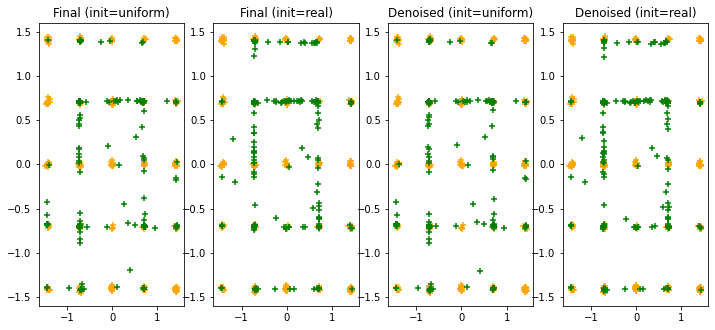

In [ ]:
# uncond, 10 steps alpha=.20, 10 sigma from [.01,1]
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.01,1], n_sigma = 10, samp_sigma_range = [.01,1], n_steps_each=10, alpha=.20, samp_n_sigma = 10, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.125755
GAN_seed1: Distance_total = 0.011342, Distance_to_real = 0.008276, Distance_to_fake = 0.003066


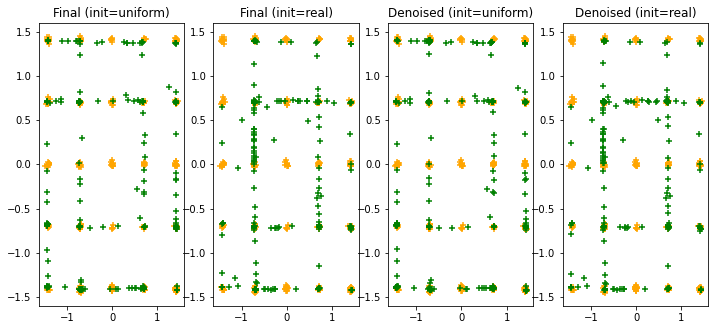

In [ ]:
# uncond, 10 steps alpha=.10, 10 sigma from [.01,1]
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.01,1], n_sigma = 10, samp_sigma_range = [.01,1], n_steps_each=10, alpha=.10, samp_n_sigma = 10, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.125755
GAN_seed1: Distance_total = 0.099995, Distance_to_real = 0.097123, Distance_to_fake = 0.002872


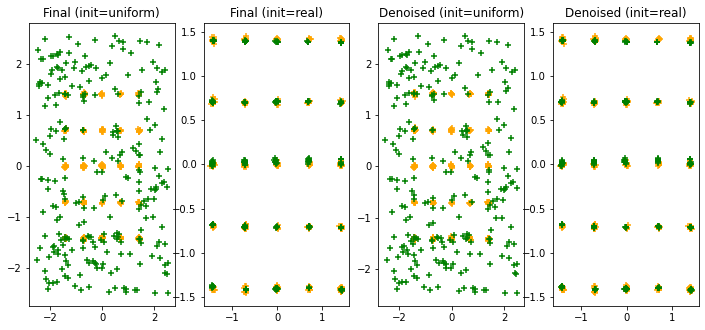

In [ ]:
# uncond, 10 steps alpha=.01, 10 sigma from [.01,1]
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.01,1], n_sigma = 10, samp_sigma_range = [.01,1], n_steps_each=10, alpha=.01, samp_n_sigma = 10, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 4.325855
GAN_seed1: Distance_total = 0.044176, Distance_to_real = 0.038884, Distance_to_fake = 0.005293


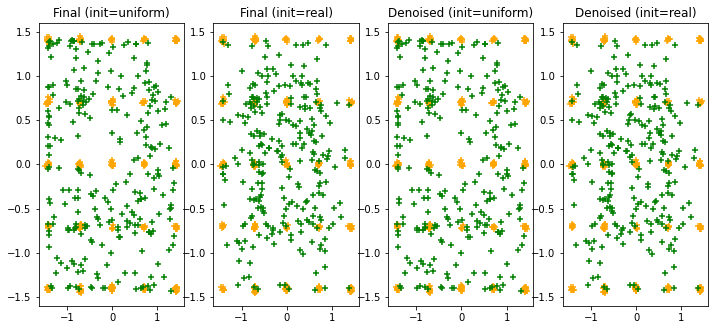

In [ ]:
# uncond, 10 steps alpha=.20, 10 sigma from [.0001,1]
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.0001,1], n_sigma = 10, samp_sigma_range = [.0001,1], n_steps_each=10, alpha=.20, samp_n_sigma = 10, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 4.325855
GAN_seed1: Distance_total = 0.044176, Distance_to_real = 0.038884, Distance_to_fake = 0.005293


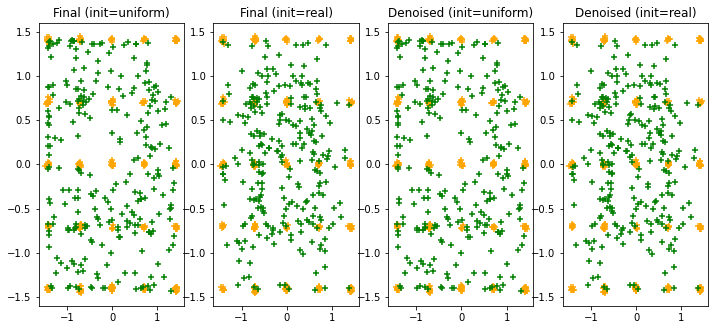

In [ ]:
# uncond, 10 steps alpha=.01, 10 sigma from [.0001,1]
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.0001,1], n_sigma = 10, samp_sigma_range = [.0001,1], n_steps_each=10, alpha=.20, samp_n_sigma = 10, lr_G = 0.001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.370311
GAN_seed1: Distance_total = 0.032551, Distance_to_real = 0.016960, Distance_to_fake = 0.015590


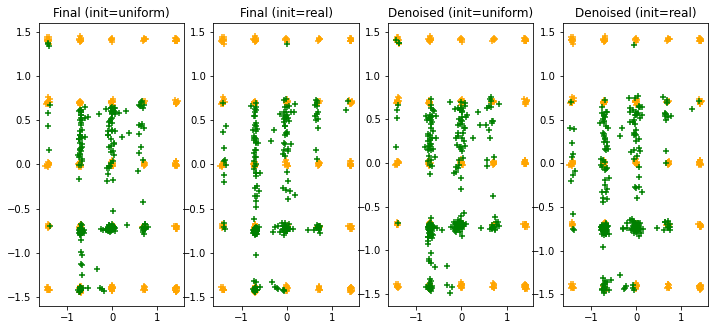

In [ ]:
# uncond, 10 steps alpha=.01, 10 sigma from [.1,1]
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,1], n_sigma = 10, samp_sigma_range = [.1,1], n_steps_each=10, alpha=.20, samp_n_sigma = 10, lr_G = 0.001)

## Hybrid GAN + DAE

[1999/2000] Loss_D: 0.451702 Loss_G: 0.003053 Loss_G_dae: 4.022203
seed1: Distance_total = 0.003172, Distance_to_real = 0.001824, Distance_to_fake = 0.001348


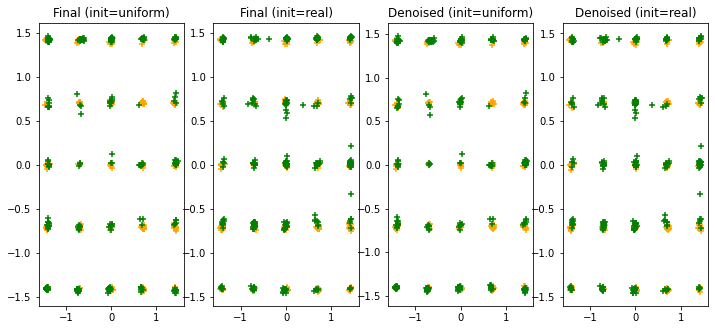

In [ ]:
# uncond, 10 steps alpha=.5, 10 sigma from [.01,.2] (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.01,.2], n_sigma = 10, samp_sigma_range = [.01,.2], n_steps_each=10, alpha=.5, samp_n_sigma = 10, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L2', target='zscore')

# Experiments with a single small sigma

alpha=1

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.381661
GAN_seed1: Distance_total = 0.018490, Distance_to_real = 0.016727, Distance_to_fake = 0.001762


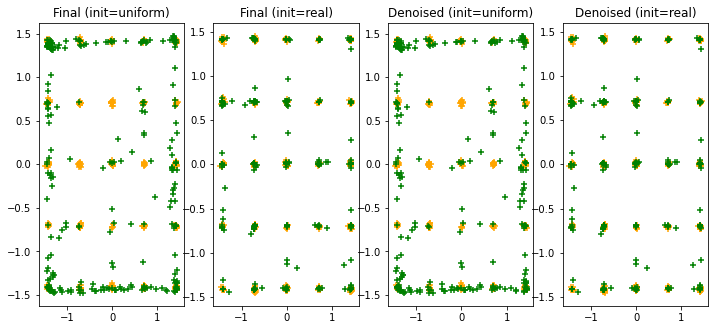

In [ ]:
# uncond, 1 steps alpha=1, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=1, alpha=1, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.305167
GAN_seed1: Distance_total = 0.009762, Distance_to_real = 0.007746, Distance_to_fake = 0.002016


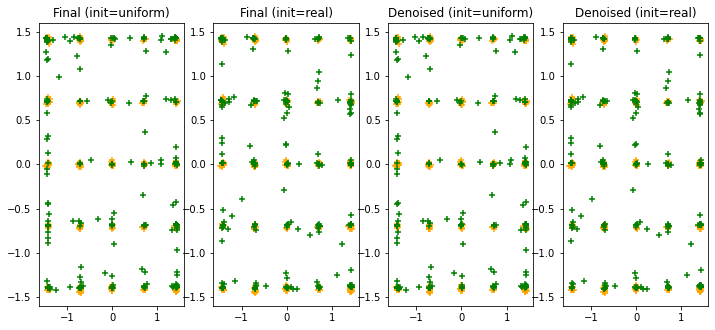

In [ ]:
# uncond, 10 steps alpha=1, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=1, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.448866
GAN_seed1: Distance_total = 0.009140, Distance_to_real = 0.007496, Distance_to_fake = 0.001644


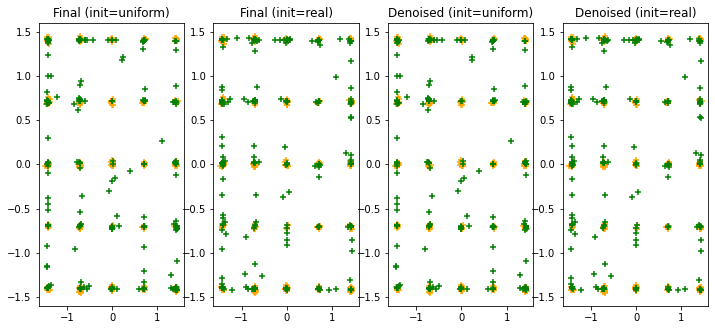

In [ ]:
# uncond, 100 steps alpha=1, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=1, samp_n_sigma = 1, lr_G = 0.0001)

alpha=.5

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.305167
GAN_seed1: Distance_total = 0.004286, Distance_to_real = 0.001850, Distance_to_fake = 0.002437


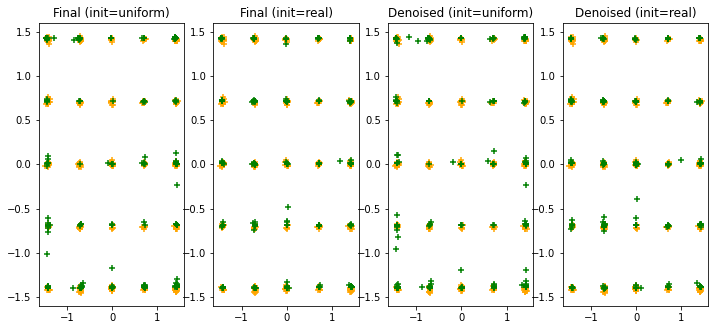

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.340932
GAN_seed1: Distance_total = 0.003926, Distance_to_real = 0.001483, Distance_to_fake = 0.002443


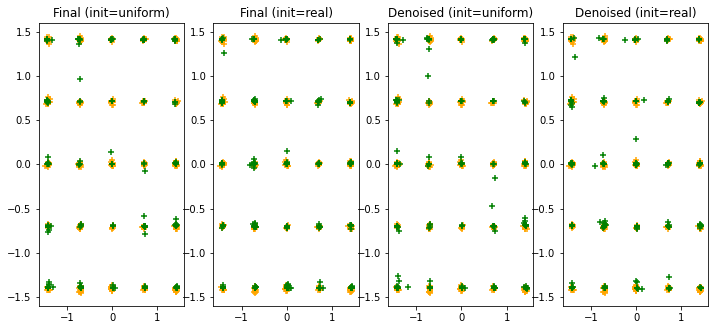

In [ ]:
# uncond, 100 steps alpha=.5, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=1000, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 2.641600
GAN_seed1: Distance_total = 0.005223, Distance_to_real = 0.001776, Distance_to_fake = 0.003447


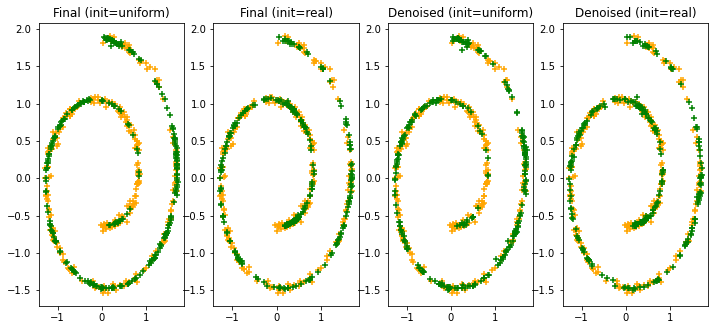

In [ ]:
# uncond, 100 steps alpha=.5, sigma=.1 
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001)

alpha=.2

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.305167
GAN_seed1: Distance_total = 0.005515, Distance_to_real = 0.002861, Distance_to_fake = 0.002655


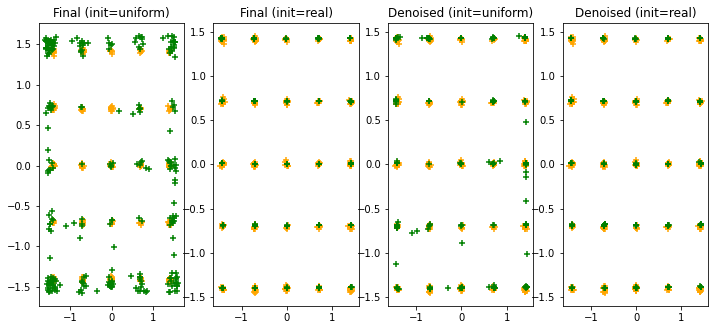

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 2.961563
GAN_seed1: Distance_total = 0.010348, Distance_to_real = 0.006883, Distance_to_fake = 0.003464


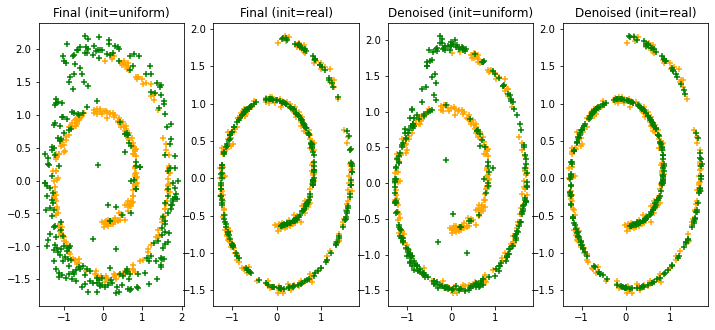

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1 
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.448866
GAN_seed1: Distance_total = 0.003400, Distance_to_real = 0.000361, Distance_to_fake = 0.003039


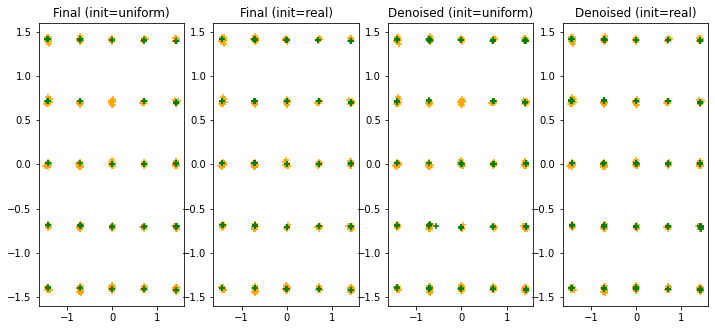

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 2.641600
GAN_seed1: Distance_total = 0.006220, Distance_to_real = 0.001610, Distance_to_fake = 0.004610


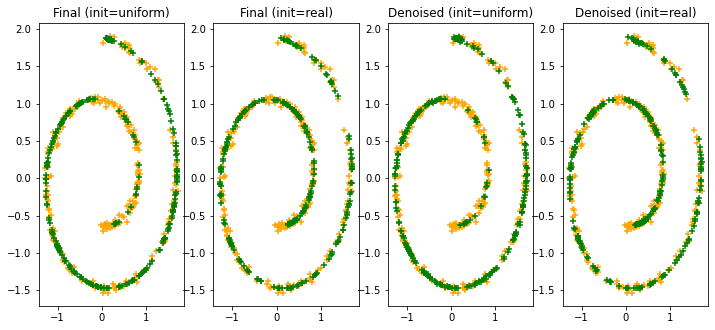

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1 
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 3.282532
GAN_seed1: Distance_total = 0.005405, Distance_to_real = 0.001715, Distance_to_fake = 0.003690


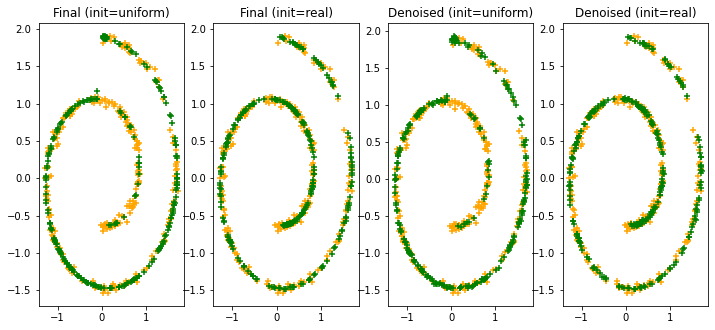

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.05 
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.05,.05], n_sigma = 1, samp_sigma_range = [.05,.05], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 4.851715
GAN_seed1: Distance_total = 0.155811, Distance_to_real = 0.147686, Distance_to_fake = 0.008126


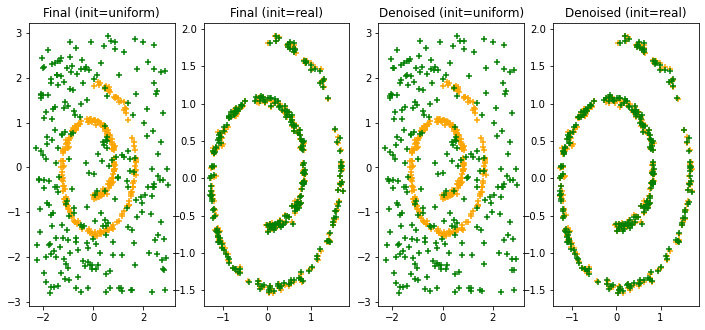

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.01
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.01,.01], n_sigma = 1, samp_sigma_range = [.01,.01], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001)

alpha=.1

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.305167
GAN_seed1: Distance_total = 0.008693, Distance_to_real = 0.006556, Distance_to_fake = 0.002138


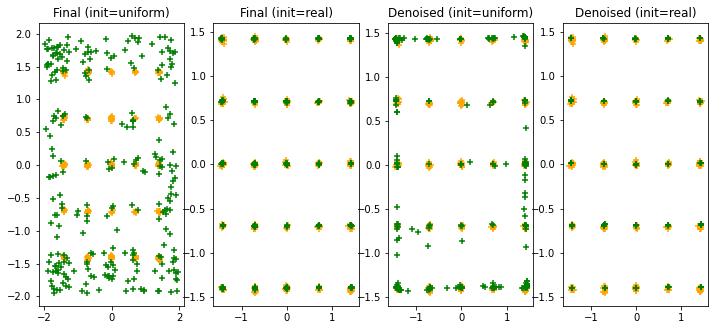

In [ ]:
# uncond, 10 steps alpha=.1, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.1, samp_n_sigma = 1, lr_G = 0.0001)

alpha=.01

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.305167
GAN_seed1: Distance_total = 0.017348, Distance_to_real = 0.015319, Distance_to_fake = 0.002029


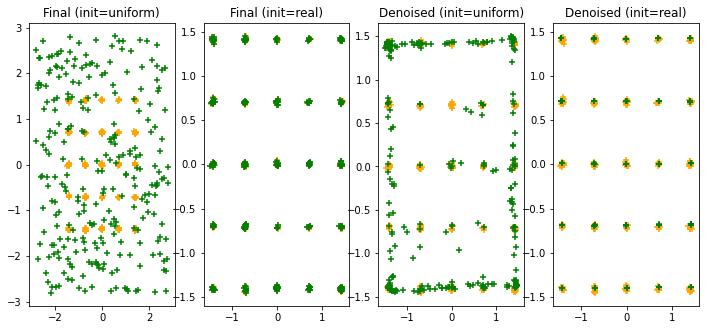

In [ ]:
# uncond, 10 steps alpha=.01, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.01, samp_n_sigma = 1, lr_G = 0.0001)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.305167
GAN_seed1: Distance_total = 0.017348, Distance_to_real = 0.015319, Distance_to_fake = 0.002029


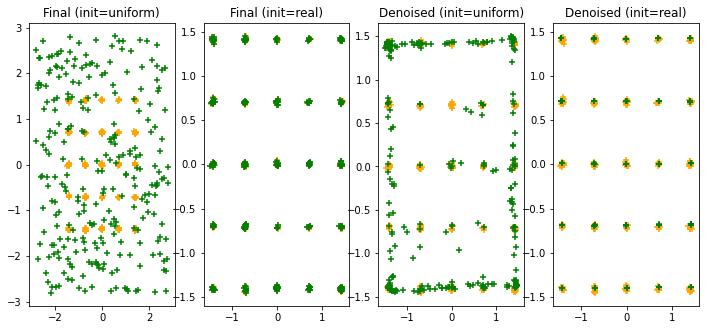

In [ ]:
# uncond, 100 steps alpha=.01, sigma=.1 
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.01, samp_n_sigma = 1, lr_G = 0.0001)

## Hybrid GAN + DAE

[1999/2000] Loss_D: 0.497267 Loss_G: 0.002495 Loss_G_dae: 5.709140
seed1: Distance_total = 0.047999, Distance_to_real = 0.044027, Distance_to_fake = 0.003971


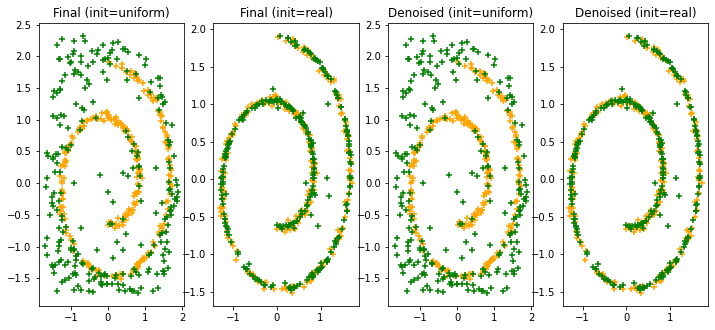

In [ ]:
# uncond, 1 steps alpha=1, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=1, alpha=1, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.498888 Loss_G: 0.002550 Loss_G_dae: 5.824141
seed1: Distance_total = 0.010014, Distance_to_real = 0.006452, Distance_to_fake = 0.003562


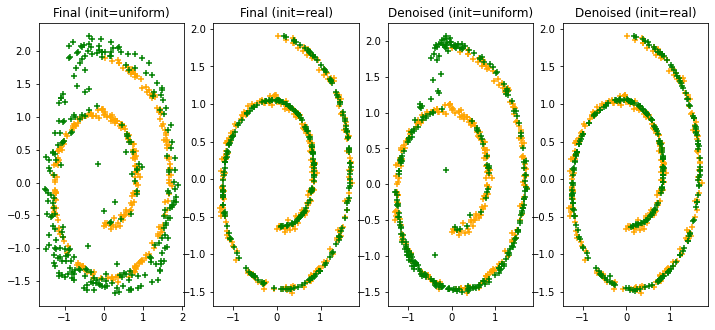

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.498888 Loss_G: 0.002550 Loss_G_dae: 5.824141
seed1: Distance_total = 0.006263, Distance_to_real = 0.002362, Distance_to_fake = 0.003901


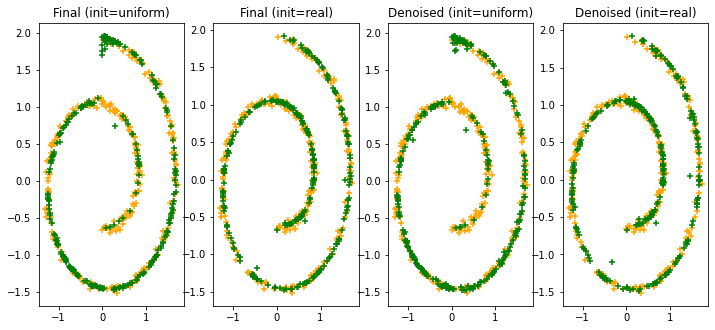

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.486049 Loss_G: 0.002809 Loss_G_dae: 2.080994
seed1: Distance_total = 0.005204, Distance_to_real = 0.003081, Distance_to_fake = 0.002123


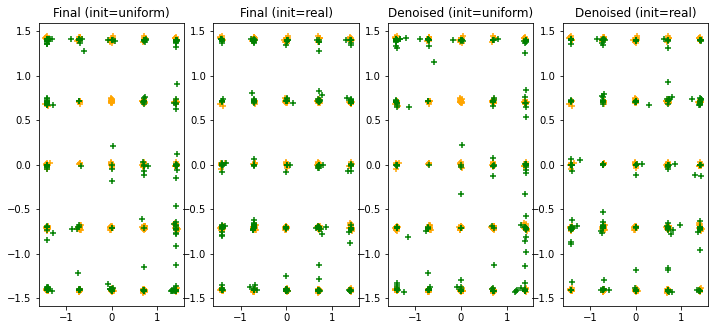

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.488808 Loss_G: 0.002970 Loss_G_dae: 2.680671
seed1: Distance_total = 0.003102, Distance_to_real = 0.000449, Distance_to_fake = 0.002653


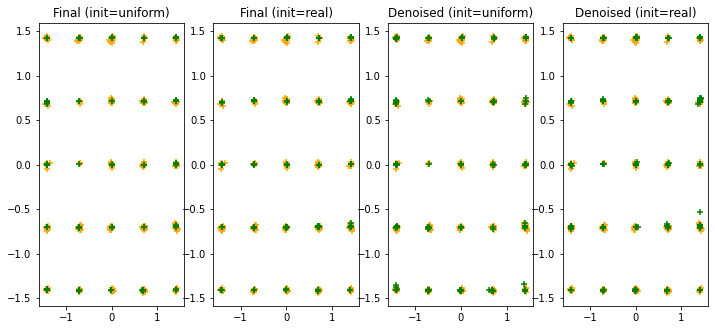

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1 (.01*LSGAN+10*DAE) ## Best model ever
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.488720 Loss_G: 0.304006 Loss_G_dae: 2.747043
seed1: Distance_total = 0.003053, Distance_to_real = 0.000418, Distance_to_fake = 0.002635


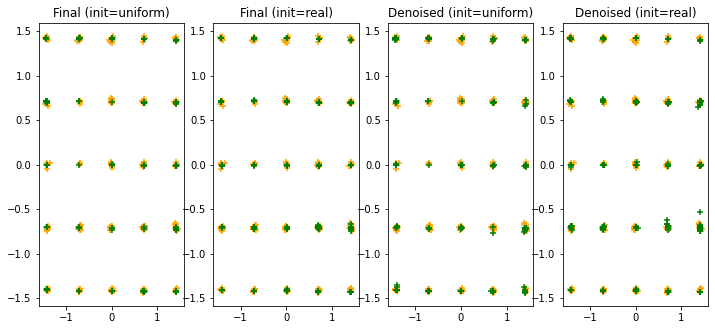

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1 (1*GAN + 10*DAE)
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 1, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.497416 Loss_G: 0.002544 Loss_G_dae: 0.057995
seed1: Distance_total = 0.006109, Distance_to_real = 0.002255, Distance_to_fake = 0.003854


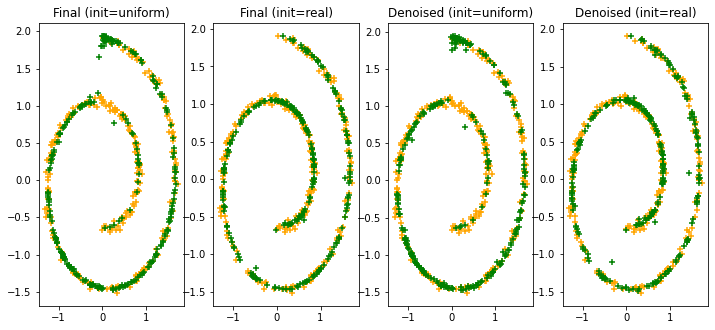

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 (.01*LSGAN+.1*DAE)
run_experiment(seed = [1], opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = .1, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

## Hybrid GAN + DAE  (beta1 = .5)

beta1 = .5 for ADAM is the normal default in GANs

[1999/2000] Loss_D: 0.495812 Loss_G: 0.002292 Loss_G_dae: 5.758990
seed1: Distance_total = 0.051122, Distance_to_real = 0.047226, Distance_to_fake = 0.003896


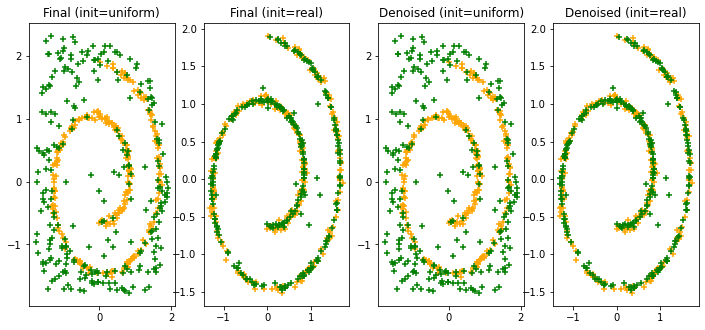

In [ ]:
# uncond, 1 steps alpha=1, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_niter = 2000, opt_beta1=.5, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=1, alpha=1, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.498427 Loss_G: 0.002408 Loss_G_dae: 5.763760
seed1: Distance_total = 0.010890, Distance_to_real = 0.007581, Distance_to_fake = 0.003309


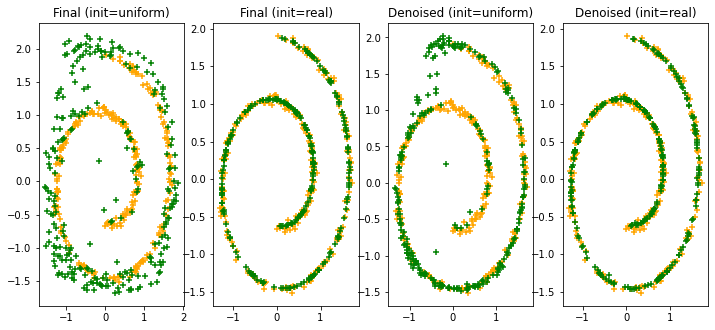

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_niter = 2000, opt_beta1=.5, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.498427 Loss_G: 0.002408 Loss_G_dae: 5.763760
seed1: Distance_total = 0.006066, Distance_to_real = 0.002427, Distance_to_fake = 0.003639


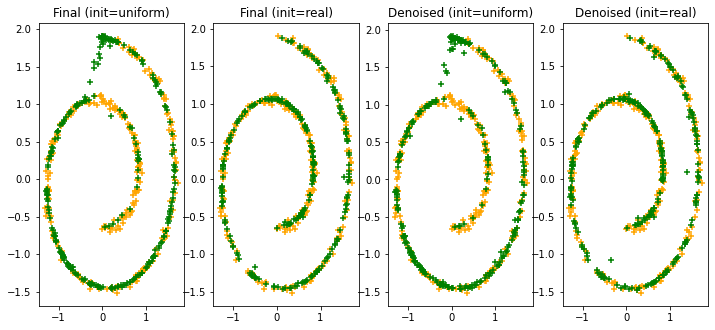

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_niter = 2000, opt_beta1=.5, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.458962 Loss_G: 0.002653 Loss_G_dae: 3.095187
seed1: Distance_total = 0.010744, Distance_to_real = 0.007203, Distance_to_fake = 0.003541


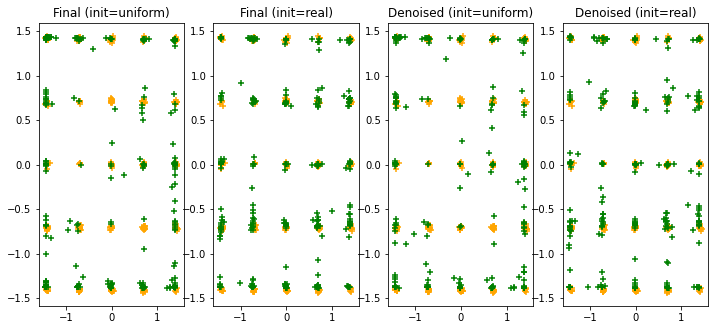

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_beta1=.5, opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.460825 Loss_G: 0.003747 Loss_G_dae: 3.696703
seed1: Distance_total = 0.004502, Distance_to_real = 0.001016, Distance_to_fake = 0.003487


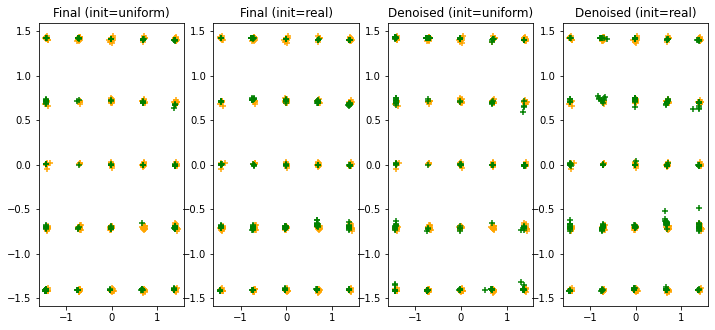

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_beta1=.5, opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.497951 Loss_G: 0.002433 Loss_G_dae: 0.057603
seed1: Distance_total = 0.006037, Distance_to_real = 0.002380, Distance_to_fake = 0.003657


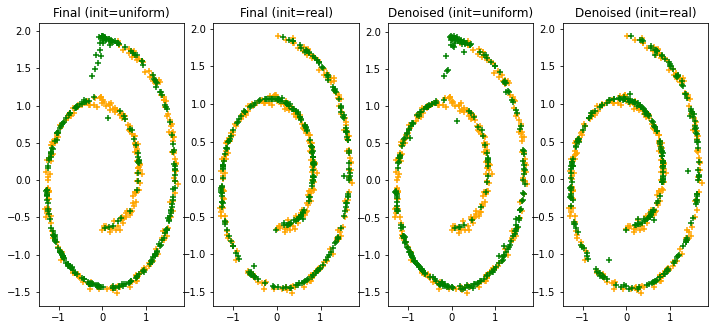

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 (.01*LSGAN+.1*DAE)
run_experiment(seed = [1], opt_niter = 2000, opt_beta1=.5, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = .1, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

In [ ]:
## Hybrid GAN + DAE  (beta1 = 0, beta2 = .90)

[1999/2000] Loss_D: 0.445021 Loss_G: 0.002661 Loss_G_dae: 4.738504
seed1: Distance_total = 0.018836, Distance_to_real = 0.013135, Distance_to_fake = 0.005701


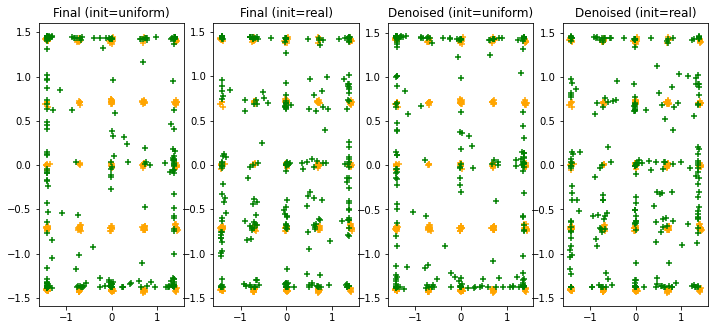

In [ ]:
# uncond, 10 steps alpha=.5, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_beta1=0, opt_beta2=.9, opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.5, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.449564 Loss_G: 0.004165 Loss_G_dae: 5.316633
seed1: Distance_total = 0.010856, Distance_to_real = 0.003197, Distance_to_fake = 0.007659


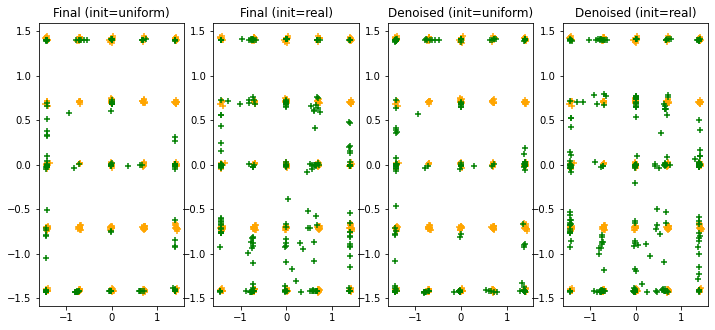

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1 (.01*LSGAN+10*DAE)
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_beta1=0, opt_beta2=.9, opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = .01, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

# Other models

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 2.167357
seed1: Distance_total = 0.003105, Distance_to_real = 0.000413, Distance_to_fake = 0.002692


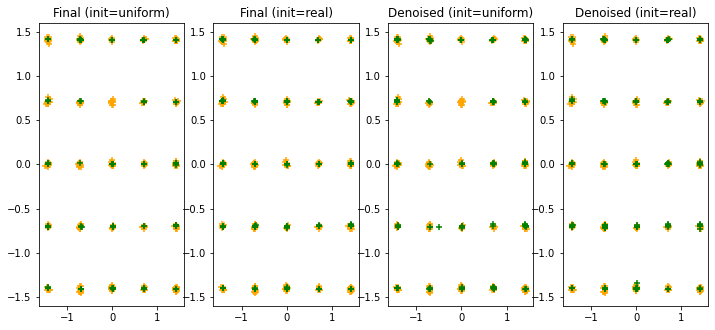

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 5.546426
seed1: Distance_total = 0.006323, Distance_to_real = 0.001689, Distance_to_fake = 0.004634


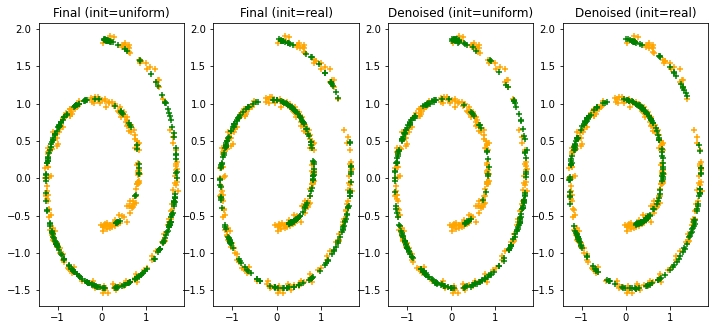

In [ ]:
# uncond, 100 steps alpha=.2, sigma=.1
run_experiment(seed = [1], opt_niter = 2000, loss_D=2, Diters=1, Giters=1, prefix=None, plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=100, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, exp_reduct=1, DAE_loss_type = 'L1')

# Plots for the paper

In [ ]:
from matplotlib import pyplot
%matplotlib inline
  pyplot.rcParams['figure.figsize'] = [6, 4]
import IPython

FileNotFoundError: ignored

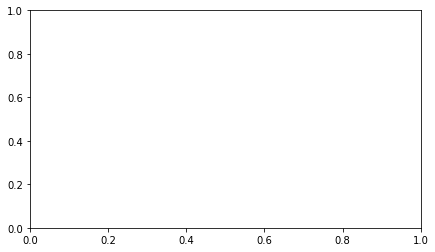

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix='1', plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, target='zscore', paper_plot=True)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 2.968990


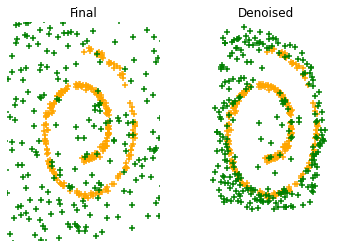

In [ ]:
# uncond, 10 steps alpha=.01, sigma=.1
run_experiment(seed = [1], opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix='1', plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.01, samp_n_sigma = 1, lr_G = 0.0001, target='zscore', paper_plot=True)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.319961


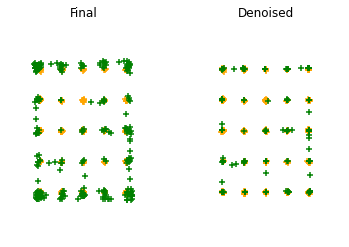

In [ ]:
# uncond, 10 steps alpha=.2, sigma=.1
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix='3', plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.2, samp_n_sigma = 1, lr_G = 0.0001, target='zscore', paper_plot=True)

[1999/2000] Loss_D: 0.000000 Loss_G: 0.000000 Loss_G_dae: 0.302129


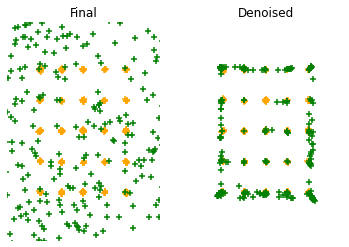

In [ ]:
## uncond, 10 steps alpha=.01, sigma=.1
run_experiment(seed = [1], opt_dataset = '25gaussians', opt_niter = 2000, loss_D=1, Diters=1, Giters=1, prefix='4', plot_often=500, GAN_loss = 0, DAE_loss = 10, sigma_range = [.1,.1], n_sigma = 1, samp_sigma_range = [.1,.1], n_steps_each=10, alpha=.01, samp_n_sigma = 1, lr_G = 0.001, target='zscore', paper_plot=True)

# Paper - Figure 1


In [ ]:
import math
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import torch

from scipy.interpolate import interp1d
from functools import partial

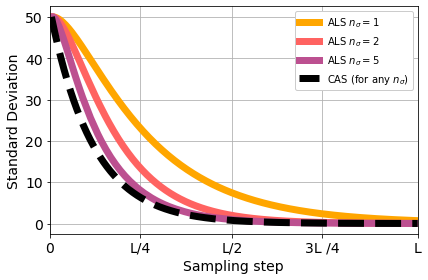

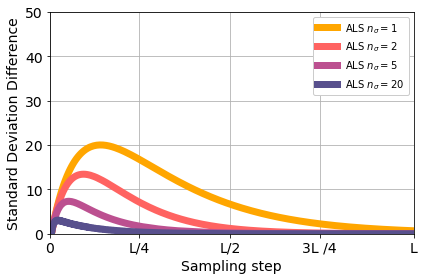

In [ ]:
def compute_ALS_std(n_sigma, sigmas, eta):
    v = sigmas[0]
    res = [v]

    for s in sigmas:
        for _ in range(n_sigma):
            v = np.sqrt( v**2 * (1 - eta)**2 + 2*eta*s**2)
            res += [v]
    return np.array(res)
            
def compute_alg2_variance(sigmas, eps, nsigma=100):
    res = [sigmas[0]]
    gamma = (sigmas[1] / sigmas[0])
    beta = np.sqrt(1 - ((1-eps)/gamma)**2)
    i_cons = sigmas[0]
    for s in sigmas:
        i_cons = np.sqrt((i_cons - eps*s)**2 + (gamma*s*beta)**2)
        res += [i_cons]
    return np.array(res)

def linplot(data, label=None, color=None, showpoints=False, showline=True, kwargs=None):
    kwargs = {} if kwargs is None else kwargs
    x = np.linspace(0, 1, num=len(data), endpoint=True)
    f = interp1d(x, data)
    xaxis = x * 231  + 1
    if showpoints and showline:
        plt.plot(xaxis, data, 'o', xaxis, f(x), '-', linewidth=5, label=label, color=color, s=0.1)
    elif showpoints:
        plt.scatter(xaxis, data, label=label, color=color, s=0.1)
    else:
        kwargs_ = {'color': color, 'linewidth': 7, 'ls': '-'}
        plt.plot(xaxis, f(x), label=label, **{**kwargs_, **kwargs})

def plot_Figure1(savepath=None): 

    ff = partial(compute_ALS_std, sigmas=np.geomspace(50, 0.01, 232), eta=2e-6 / (0.01**2))  # 7e-6
    rr_code_1 = ff(1)
    rr_code_2 = ff(2)
    rr_code_5 = ff(5)
    rr_code_20 = ff(20)
    rr_code_100 = ff(100)
    rr_cons = compute_alg2_variance(np.geomspace(50, 0.01, (232*100 + 1)), eps=2e-5 / (0.01 ** 2))

    plt.figure(figsize = (6, 4))
    linplot(rr_code_1, label=r"ALS $n_\sigma=1$", color="#ffa600")
    linplot(rr_code_2, label="ALS $n_\sigma=2$", color="#ff6361")
    linplot(rr_code_5, label="ALS $n_\sigma=5$", color="#bc5090")
    # linplot(rr_code_20, label="Code algorithm (n=20)")
    linplot(rr_cons, label=r"CAS (for any $n_\sigma$)", kwargs={'color': 'black', 'linewidth': 7, 'ls': '--'})
    plt.legend(fancybox=True, framealpha=1)#, shadow=True)#frameon=False)
    plt.xlabel("Sampling step", size=14)
    plt.ylabel("Standard Deviation", size=14)
    plt.yticks(size=14)
    plt.xticks([0, 57, 115, 172, 232], ['0', 'L/4', 'L/2', '3L /4', 'L'], size=14)
    plt.tight_layout()
    plt.xlim(0, 232)
    # plt.ylim(0, 50)
    plt.grid()
    plt.savefig("fig_std.png", bbox_inches = 'tight', dpi=600)#, pad_inches = 0)
    plt.show()

    plt.figure(figsize = (6, 4))
    linplot(rr_code_1 - np.array(rr_cons[::100]), label="ALS $n_\sigma=1$", color="#ffa600")
    linplot(rr_code_2 - np.array(rr_cons[::50]), label="ALS $n_\sigma=2$", color="#ff6361")
    linplot(rr_code_5 - np.array(rr_cons[::20]), label="ALS $n_\sigma=5$", color="#bc5090")
    linplot(rr_code_20 - np.array(rr_cons[::5]), label="ALS $n_\sigma=20$", color="#58508d")
    # linplot(rr_code_100 - np.array(rr_cons[::1][:-1]), label="Code algorithm (n=100)")
    plt.legend(fancybox=True, framealpha=1)#, shadow=True)#frameon=False)
    plt.xlabel("Sampling step", size=14)
    plt.yticks(size=14)
    plt.xticks([0, 57, 115, 172, 232], ['0', 'L/4', 'L/2', '3L /4', 'L'], size=14)
    plt.xlim(0, 232)
    plt.ylim(0, 50)
    plt.ylabel("Standard Deviation Difference", size=14)
    plt.tight_layout()
    plt.grid()
    #plt.show()
    ax = plt.gca()
    #ax.axes.yaxis.set_ticklabels([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches = 'tight', dpi=600)

plot_Figure1()

# Paper - Figure 3

In [ ]:
def plotlrax(ax, CAS, ALS, sigmas=None, K=None, showpoints=False, showlines=True, betascale=False, logscale=False,
             ylim=None, xlim=None):
    
    order = np.argsort(CAS[:, 0])
    CAS_stepsize = CAS[:, 0][order]
    CAS_nd = CAS[:, 1][order]
    CAS_d = CAS[:, 2][order]
    
    order = np.argsort(ALS[:, 0])
    ALS_stepsize = ALS[:, 0][order]
    ALS_nd = ALS[:, 1][order]
    ALS_d = ALS[:, 2][order]

    color_denoised = '#f2af29'
    
    def f(x):
        if betascale:
            assert sigmas is not None and K is not None
            x = compute_beta(sigmas, x, K=K)
        if logscale:
            x = np.log(x)
        return x
     
    if showlines:
        CAS_fA = interp1d(CAS_stepsize, CAS_nd)# 9B4F96
        CAS_fB = interp1d(CAS_stepsize, CAS_d)
        
        ALS_fA = interp1d(ALS_stepsize, ALS_nd)
        ALS_fB = interp1d(ALS_stepsize, ALS_d)  # ff6361
        
        ax.plot(f(ALS_stepsize)*0.88 - 0.8e-5, ALS_fA(ALS_stepsize), '-', linewidth=6, label="ALS non-denoised", color="#ffa600") # ffa600
        ax.plot(f(CAS_stepsize), CAS_fA(CAS_stepsize), '-', linewidth=6, label="CAS non-denoised", color="#ff6361") # 58508d
        
        #ax.plot(f(ALS_stepsize) - 0.996e-5, ALS_fA(ALS_stepsize), '-', linewidth=6, label="ALS non-denoised", color="#ff6361") # ffa600
        ax.plot(f(ALS_stepsize)*0.88 - 0.8e-5, ALS_fB(ALS_stepsize), '-', linewidth=6, label="ALS denoised", color="#bc5090")
        ax.plot(f(CAS_stepsize), CAS_fB(CAS_stepsize), '-', linewidth=6, label="CAS denoised", color="#003f5c")  # 003f5c
        
    ax.legend(loc=9, ncol=2)
    xlabel = "Beta" if betascale else r"CAS Sampling Step Size ($\epsilon$)"
    xlabel = "log ( " + xlabel + " )" if logscale else xlabel
    ax.set_xlabel(xlabel, size=14)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel(f"Partial FID (5'000 samples)", size=14)
    ax.set_ylim(*([10, 40] if ylim is None else ylim))
    ax.set_xlim(*([None, None] if xlim is None else xlim))
    ax.grid()
    
    
def plot_Figure3(CAS, ALS, savepath=None):
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    
    
    plotlrax(ax, CAS, ALS, ylim=[10, 80], xlim=[0.3e-5, 3.0e-5])
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    new_tick_locations = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
    
    #ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    #ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    #ax2.spines['bottom'].set_position(('outward', 56))
    ax2.set_xticks((new_tick_locations*0.88 - 0.8))
    ax2.set_xticklabels(new_tick_locations, size=15)
    ax2.set_xlabel(r"ALS Sampling Step Size ($\epsilon$)", size=14, labelpad=10)
    
    if savepath is not None:
        plt.savefig(savepath,  bbox_inches = 'tight', dpi=600)
    

CAS = np.load("fids/cifar10_ncsnv2/c_adv_n1_5k.npy")
ALS = np.load("fids/cifar10_ncsnv2/nc_adv_n1_5k.npy")
plot_Figure3(CAS, ALS)